In [ ]:
# Load all the modules we need
# For plotting
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import datetime

# For ML
import sklearn

# For data manipulation
import numpy as np
import pandas as pd

# This makes all the plots to be shown within jupyter
%matplotlib inline
# Setting the default plot size
matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)

First load the Excel sheet using pandas and then load each page into a new data frame

In [ ]:
xlsx = pd.ExcelFile('Project.xlsx')

In [ ]:
customer_order = xlsx.parse('customer order')
material_master = xlsx.parse('Material Master')
sales_past_demand = xlsx.parse('sales past demand')
customer_master = xlsx.parse('Customer Master')
invoice = xlsx.parse('Invoice')
stock_master = xlsx.parse('stock master')
delivery_data = xlsx.parse('Delivery data')
booking_data = xlsx.parse('Booking details')

# Pre-processing of data

## customer order

In [ ]:
pd.isnull(customer_order).describe()

,SONO,ITEM,PTNO,DESC,DATE,ORD_QTY,CUST,PLNT,Price,customer PO ref,PO date
count,39398,39398,39398,39398,39398,39398,39398,39398,39398,39398,39398
unique,1,1,1,1,1,1,1,2,1,1,1
top,False,False,False,False,False,False,False,False,False,False,False
freq,39398,39398,39398,39398,39398,39398,39398,39388,39398,39398,39398


There is some missing data in PLNT. Lets see what they are.

Since there are only 10 values missing, lets fill it with the most common PLNT values.

In [ ]:
customer_order.PLNT.describe()

count    39388.000000
mean       861.837869
std        196.784207
min        130.000000
25%        930.000000
50%        930.000000
75%        930.000000
max        930.000000
Name: PLNT, dtype: float64

In [ ]:
customer_order.PLNT.fillna(930, inplace=True)

In [ ]:
pd.isnull(customer_order).describe()

,SONO,ITEM,PTNO,DESC,DATE,ORD_QTY,CUST,PLNT,Price,customer PO ref,PO date
count,39398,39398,39398,39398,39398,39398,39398,39398,39398,39398,39398
unique,1,1,1,1,1,1,1,1,1,1,1
top,False,False,False,False,False,False,False,False,False,False,False
freq,39398,39398,39398,39398,39398,39398,39398,39398,39398,39398,39398


__pd.to_datetime(customer_order['PO date'])__ gives an error due to some strings which are set to 00:00:00. So we need to remove these first, we do this by setting PO date to the DATE

In [ ]:
customer_order[customer_order['PO date'] == datetime.time(0)].count()

SONO               397
ITEM               397
PTNO               397
DESC               397
DATE               397
ORD_QTY            397
CUST               397
PLNT               397
Price              397
customer PO ref    397
PO date            397
dtype: int64

### Check date format

In [ ]:
customer_order['DATE'][:2]

0    23-08-2016
1    23-08-2016
Name: DATE, dtype: object

In [ ]:
customer_order['PO date'][:2]

0    2016-08-23 00:00:00
1    2206-08-19 00:00:00
Name: PO date, dtype: object

Fill in the missing 'PO date' with the corresponding values from 'DATE'. To do this, first get the month and day from each corresponding 'DATE' value. and using this and the year (2016) create a datetime.date and assign it to 'PO DATE'

In [ ]:
tmp = customer_order[customer_order['PO date'] == datetime.time(0)]
day, month = [], []
for i in tmp['DATE'].str.split('-').values:
    day.append(int(i[0]))
    month.append(int(i[1]))
customer_order.loc[customer_order['PO date'] == datetime.time(0), 'PO date'] = [datetime.date(2016, m, d) for m, d in zip(month, day)]

In [ ]:
customer_order['PO date'] = pd.to_datetime(customer_order['PO date'], format='%Y/%m/%d')

customer_order['DATE'] = pd.to_datetime(customer_order['DATE'], format='%d-%m-%Y')

In [ ]:
x = (customer_order['DATE'] - customer_order['PO date'])
customer_order[x.dt.days < 0]

As you can see above there are still ~80 rows which have date > po date, this could perhaps be deleted.

In [ ]:
customer_order.drop(customer_order[x.dt.days < 0].index, inplace=True)

## material_master

In [ ]:
pd.isnull(material_master).describe()

,Material code`,Material Description,Type,Unit,Model,safety stock,Demand
count,6022,6022,6022,6022,6022,6022,6022
unique,1,1,1,1,1,1,1
top,False,False,False,False,False,False,False
freq,6022,6022,6022,6022,6022,6022,6022


No null values here, lets just remove unwated columns: 1. Type 2. Unit

In [ ]:
material_master.drop(['Type', 'Unit'], axis=1, inplace=True)

In [ ]:
material_master.columns

Index([u'Material code`', u'Material Description', u'Model', u'safety stock',
       u'Demand'],
      dtype='object')

In [ ]:
material_master.rename(columns={'Material code`': 'Material code'}, inplace=True)

## sales past demand


In [ ]:
sales_past_demand.head()

,Material code`,DEM36,DEM35,DEM34,DEM33,DEM32,DEM31,DEM30,DEM29,DEM28,...,DEM10,DEM9,DEM8,DEM7,DEM6,DEM5,DEM4,DEM3,DEM2,DEM1
0,01010-61435I.,6,0,0,0,0,0,5,0,0,...,0,4,0,0,16,12,2,0,0,0
1,01010-61455I.,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2,0,0
2,01010-61635I.,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,8,1,0
3,01010-61645I.,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,0
4,01010-61650I.,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,2,0,0,0,0


This holds the sales demands for given materials for the last 36months, this could be used to make predicitons for future demands. No pre-processing required here

In [ ]:
sales_past_demand.columns

Index([u'Material code`', u'DEM36', u'DEM35', u'DEM34', u'DEM33', u'DEM32',
       u'DEM31', u'DEM30', u'DEM29', u'DEM28', u'DEM27', u'DEM26', u'DEM25',
       u'DEM24', u'DEM23', u'DEM22', u'DEM21', u'DEM20', u'DEM19', u'DEM18',
       u'DEM17', u'DEM16', u'DEM15', u'DEM14', u'DEM13', u'DEM12', u'DEM11',
       u'DEM10', u'DEM9', u'DEM8', u'DEM7', u'DEM6', u'DEM5', u'DEM4', u'DEM3',
       u'DEM2', u'DEM1'],
      dtype='object')

In [ ]:
sales_past_demand.rename(columns={'Material code`': 'Material code'}, inplace=True)

## customer_master

In [ ]:
pd.isnull(customer_master).describe()

,customer code,Name,Street,City,PostalCode,Region,Industry
count,976,976,976,976,976,976,976
unique,1,1,1,1,1,1,1
top,False,False,False,False,False,False,False
freq,976,976,976,976,976,976,976


No null values here, lets remove the unwated columns: 1. Street, 2. City

In [ ]:
customer_master.drop(['Street', 'City'], axis=1, inplace=True)

In [ ]:
customer_master.columns

Index([u'customer code', u'Name ', u'PostalCode', u'Region', u'Industry'], dtype='object')

In [ ]:
customer_master.rename(columns={'Name ': 'Name'}, inplace=True)

## invoice

In [ ]:
pd.isnull(invoice).describe()

,Bill.Doc.,Item,Material code,Description,Required quantity,Billed Quantity,Value,delivery doc,RefItm,Sales ord,so Item,Plnt,Bill date
count,39343,39343,39343,39343,39343,39343,39343,39343,39343,39343,39343,39343,39343
unique,1,1,1,1,1,1,1,1,1,1,1,1,1
top,False,False,False,False,False,False,False,False,False,False,False,False,False
freq,39343,39343,39343,39343,39343,39343,39343,39343,39343,39343,39343,39343,39343


No null values here too. Lets remove unwanted columns: 1. Refitm 2. so item

In [ ]:
invoice.drop(['so Item', 'RefItm'], axis=1, inplace=True)

Convert the date to pd_datetime

In [ ]:
invoice['Bill date'] = pd.to_datetime(invoice['Bill date'], format='%Y/%m/%d')

In [ ]:
invoice.columns

Index([u'Bill.Doc.', u'Item', u'Material code', u'Description',
       u'Required quantity', u'Billed Quantity', u'Value', u'delivery doc',
       u'Sales ord', u'Plnt', u'Bill date'],
      dtype='object')

## stock_master

In [ ]:
pd.isnull(stock_master).describe()

,Material,ValA,DocumentNo,Year,Itm,D/C,Amount,Quantity,BUn,Pstng Date
count,68555,68555,68555,68555,68555,68555,68555,68555,68555,68555
unique,1,1,1,1,1,1,1,1,1,1
top,False,False,False,False,False,False,False,False,False,False
freq,68555,68555,68555,68555,68555,68555,68555,68555,68555,68555


No null values here. Lets remove unwanted columns: 1. Year 2. ValA

In [ ]:
stock_master.drop(['ValA', 'Year'], axis=1, inplace=True)

Convert date to pd_datetime

In [ ]:
stock_master['Pstng Date'] = pd.to_datetime(stock_master['Pstng Date'], format='%Y/%m/%d')

In [ ]:
stock_master.columns

Index([u'Material', u'DocumentNo', u'Itm', u'D/C', u'Amount', u'   Quantity',
       u'BUn', u'Pstng Date'],
      dtype='object')

In [ ]:
stock_master.rename(columns={'   Quantity': 'Quantity'}, inplace=True)

## delivery data

Dropping plant and unit, as its not needed

In [ ]:
delivery_data.drop(['Plnt', 'Unit'], axis=1, inplace=True)

In [ ]:
pd.isnull(delivery_data).describe()

,Delivery no,delivery Item,Material,Delivery quantity,date,Description,sales ord,sale ord item
count,40356,40356,40356,40356,40356,40356,40356,40356
unique,1,1,1,1,1,1,1,1
top,False,False,False,False,False,False,False,False
freq,40356,40356,40356,40356,40356,40356,40356,40356


No missing data here

In [ ]:
delivery_data.columns

Index([u'Delivery no', u'delivery Item', u'Material', u'Delivery quantity',
       u'date', u'Description', u'sales ord ', u'sale ord item'],
      dtype='object')

In [ ]:
delivery_data.rename(columns={'sales ord ': 'sales ord'}, inplace=True)

## booking_data

In [ ]:
pd.isnull(booking_data).describe()

,Delivery no,Delivery date,ShPt,SOrg.,Consignment details,GC date,Recpt date
count,8445,8445,8445,8445,8445,8445,8445
unique,1,1,1,1,2,2,2
top,False,False,False,False,False,False,False
freq,8445,8445,8445,8445,7559,8441,8443


There are null values in Consigment details, GC date and Recpt date, lets have a look

In [ ]:
booking_data.loc[pd.isnull(booking_data['Consignment details']), 'Consignment details'] = "No details"

For GC date and Recpt date, we can only 3~4 rows are missing data, lets drop these rows

In [ ]:
booking_data.drop(booking_data[pd.isnull(booking_data['GC date'])].index, inplace=True)

In [ ]:
booking_data[pd.isnull(booking_data['Recpt date'])]

,Delivery no,Delivery date,ShPt,SOrg.,Consignment details,GC date,Recpt date


Luckily the fields which were missing the GC date and Recpt date, were overlapping. Lets drop unwanted rows: 1. ShPt 2. SOrg.

In [ ]:
booking_data.drop(['ShPt', 'SOrg.'], axis=1, inplace=True)

# Merging the tables

Since there are multiple tables and there is a strong relation amongst these tables, we could merge the tables for easier access and manipulation

### Customer Order and Master

In [ ]:
customer = pd.merge(customer_master, customer_order, left_on=['customer code'], right_on=['CUST'])

In [ ]:
customer.drop(['CUST'], axis=1, inplace=True)

In [ ]:
print('Customer order:', len(customer_order))
print('Customer master:', len(customer_master))
print('Customer:', len(customer))

('Customer order:', 39315)
('Customer master:', 976)
('Customer:', 39315)


No data loss here

## Bill

We can see that there is no unique key, lets try and find a combination of keys to get a unique key

Using ['Sales ord', 'Item', 'Billed Quantity'] from invoice and ['sales ord ', 'sale ord item', 'Delivery quantity'] from delivery data, we can get the unique row for merging

In [ ]:
bill = pd.merge(invoice, delivery_data, left_on=['Sales ord', 'Item', 'Billed Quantity'], right_on=['sales ord', 'sale ord item', 'Delivery quantity'])

In [ ]:
bill.drop(['sales ord', 'sale ord item', 'Delivery quantity'], axis=1, inplace=True)

In [ ]:
bill.drop(['Description_x'], axis = 1, inplace=True)
bill.rename(columns={'Description_y':'Description'}, inplace=True)

In [ ]:
bill.rename(columns={'date':'delivery date'}, inplace=True)

In [ ]:
(bill['delivery Item'] == bill['Item']).value_counts()

True    40307
dtype: int64

In [ ]:
bill.drop(['Item'], axis=1, inplace=True)

In [ ]:
len(bill.groupby(['Delivery no']).count())

7844

Now we can merge the booking data onto the bill

In [ ]:
bill = pd.merge(bill, booking_data, on='Delivery no', how='left')

# Analysis of Duplicates

## Bill

lets drop these duplicates

In [ ]:
bill.drop(bill[bill.duplicated(['Sales ord', 'Delivery no', 'Description', 'Consignment details', 'Value'])].index, inplace=True)

### Customer

In [ ]:
customer[customer.duplicated(['PTNO', 'customer code', 'SONO', 'Price', 'ITEM'], keep=False)]

,customer code,Name,PostalCode,Region,Industry,SONO,ITEM,PTNO,DESC,DATE,ORD_QTY,PLNT,Price,customer PO ref,PO date


### material_master

In [ ]:
material_master[material_master.duplicated(['Material code'], keep=False)]

,Material code,Material Description,Model,safety stock,Demand


### stock master

In [ ]:
stock_master.head(2)

,Material,DocumentNo,Itm,D/C,Amount,Quantity,BUn,Pstng Date
0,01010-61435I.,920006718,2,Recpt,167.56,4,EA,2016-04-22
1,01010-61435I.,920006757,21,Issu,167.56,4,EA,2016-04-22


In [ ]:
stock_master[stock_master.duplicated(['Material', 'Itm', 'DocumentNo'], keep=False)]

,Material,DocumentNo,Itm,D/C,Amount,Quantity,BUn,Pstng Date


### sales_past_demand

In [ ]:
sales_past_demand.head(2)

,Material code,DEM36,DEM35,DEM34,DEM33,DEM32,DEM31,DEM30,DEM29,DEM28,...,DEM10,DEM9,DEM8,DEM7,DEM6,DEM5,DEM4,DEM3,DEM2,DEM1
0,01010-61435I.,6,0,0,0,0,0,5,0,0,...,0,4,0,0,16,12,2,0,0,0
1,01010-61455I.,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2,0,0


In [ ]:
sales_past_demand[sales_past_demand.duplicated(['Material code'], keep=False)]

,Material code,DEM36,DEM35,DEM34,DEM33,DEM32,DEM31,DEM30,DEM29,DEM28,...,DEM10,DEM9,DEM8,DEM7,DEM6,DEM5,DEM4,DEM3,DEM2,DEM1


# End of Pre-Processing

Now the data has been cleaned up and duplicates have been removed. We've also merged relavant data together to get new df's.

Currently we have the following DF's:
1. bill
2. customer
3. sales_past_demand
4. stock_master
5. material master

# Data Analysis

# Order to Delivery reports

The order to delivery analysis comprises finding the following:
1. Order to delivery note generation
2. Delivery to invoice generation
3. Invoice to consignment
4. Consignment to reaching customers(Recpt date)

## 1.Order to delivery note generation


In [ ]:
# Bill is missing the PO Date, which we need, lets add that

tmp = customer[['SONO', 'PO date', 'ITEM']]
bill = bill.merge(tmp, how='left', left_on=['Sales ord', 'delivery Item'], right_on=['SONO', 'ITEM'])
bill.drop(['SONO', 'ITEM'], axis=1, inplace=True)

In [ ]:
order_to_delivery = bill[['PO date', 'Delivery date']]
order_to_delivery.loc[:, 'ORD_to_DEL'] = order_to_delivery['Delivery date'] - order_to_delivery['PO date']

/usr/lib/python2.7/site-packages/pandas/core/indexing.py:297: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/usr/lib/python2.7/site-packages/pandas/core/indexing.py:477: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [ ]:
order_to_delivery.head(2)

,PO date,Delivery date,ORD_to_DEL
0,2016-05-16,2016-06-06,21 days
1,2016-05-13,2016-06-08,26 days


In [ ]:
tmp = order_to_delivery['ORD_to_DEL'].value_counts().reset_index()
tmp.columns = ['Days', 'Count']
tmp['Days'] = tmp['Days'].apply(lambda x: x.days)
tmp.sort_values(by=['Days'], inplace=True)
tmp = tmp.reset_index().drop('index', axis=1)

In [ ]:
def display_days_difference(tmp, title):

    df = pd.DataFrame(columns=['Days', 'cum'])
    for i in xrange(7):
        df.loc[i] = [str(i) + ' days', tmp[tmp['Days'] <= i]['Count'].sum()]
    df.loc[7] = ['< 1 week', tmp[tmp['Days'] <= 7]['Count'].sum()]
    df.loc[8] = ['< 2 weeks', tmp[tmp['Days'] <= 14]['Count'].sum()]
    df.loc[9] = ['< 3 weeks', tmp[tmp['Days'] <= 21]['Count'].sum()]
    df.loc[10] = ['< 1 month', tmp[tmp['Days'] <= 30]['Count'].sum()]
    df.loc[11] = ['> 1 month', tmp['Count'].sum()]

    df['Count'] = df['cum']
    for i in xrange(11, 0, -1):
        df.loc[i, 'Count'] = df.loc[i, 'Count'] - df.loc[i - 1, 'Count']

    df['percentage'] = 100*df.Count/df.Count.sum()
    df['cum percent'] = df.percentage.cumsum()

    #setting font size
    plt.rc('axes', titlesize=30)     # fontsize of the axes title
    plt.rc('axes', labelsize=15)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=15)    # fontsize of the tick labels

    for (i, j) in [('Count', 'percentage'), ('cum', 'cum percent')]:
        fig, ax1 = plt.subplots()
        ax2 = ax1.twinx()
        ax1.bar([x for x in xrange(len(df))], df[i], width=.5, label=i)
        ax2.plot([x for x in xrange(len(df))], df[j], color='red', marker='o')
        for k in xrange(len(df)):
            ax1.text(k, df[i][k] + 300, str(float(df[j][k]))[:4], horizontalalignment='center')
        plt.xticks([x for x in xrange(len(df))], df['Days'])
        h1, l1 = ax1.get_legend_handles_labels()
        h2, l2 = ax2.get_legend_handles_labels()
        ax1.legend(h1+h2, l1+l2, loc=0)
        plt.title(title)
        plt.show()

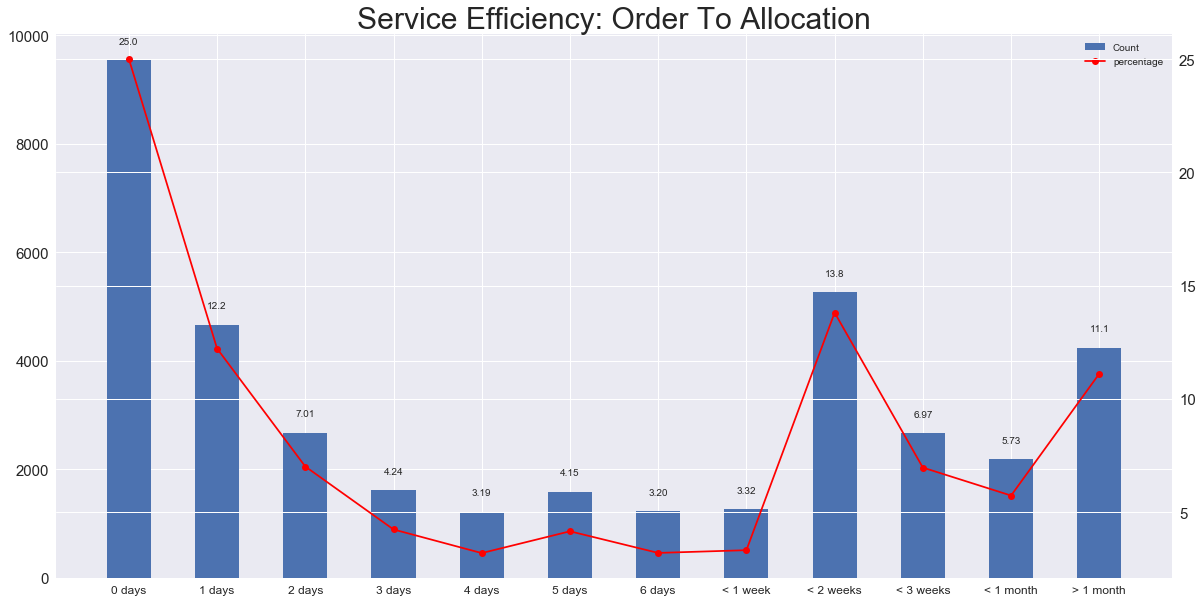

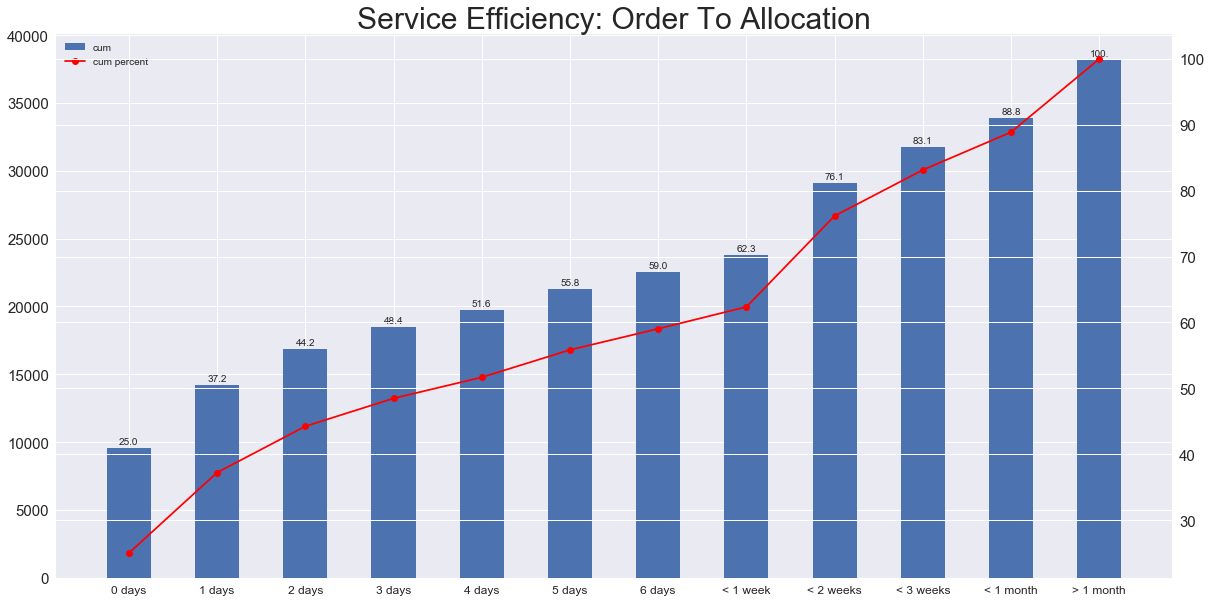

In [ ]:
display_days_difference(tmp, 'Service Efficiency: Order To Allocation')

## 2. Delivery to invoice generation.

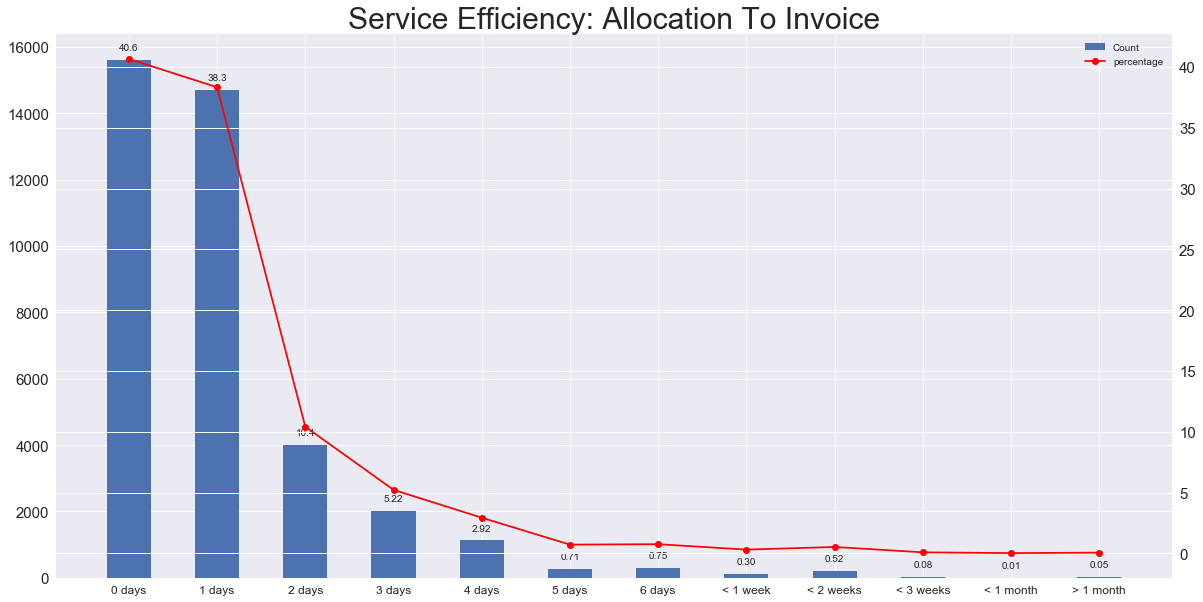

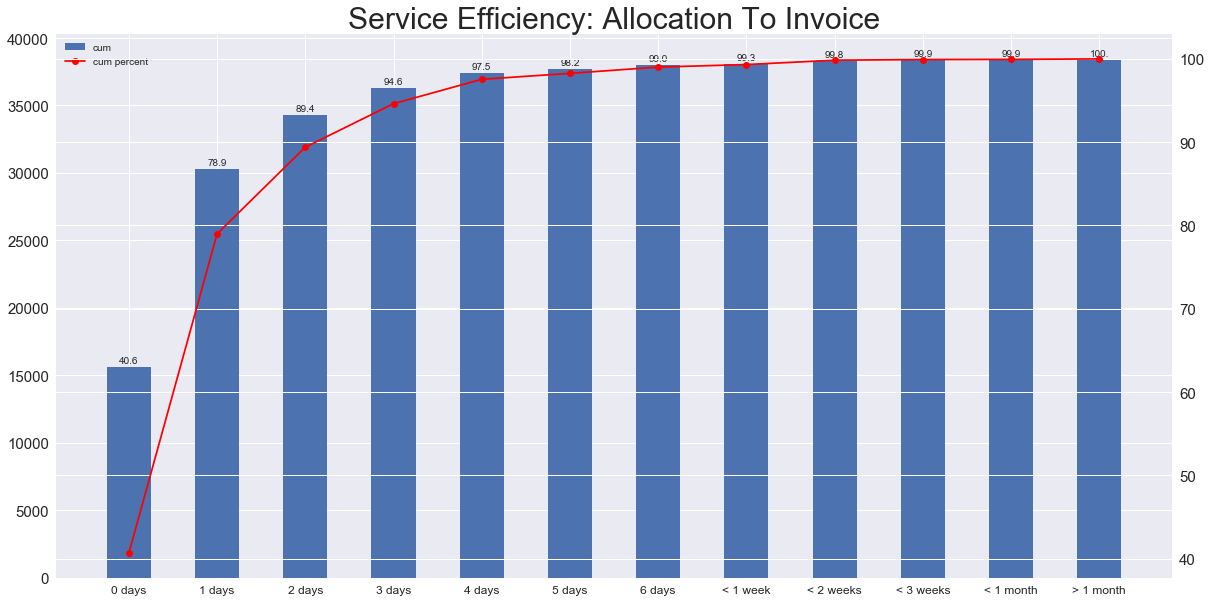

In [ ]:
delivery_to_bill = bill[['Bill date', 'Delivery date']]
delivery_to_bill.loc[:, 'DEL_TO_BILL'] = delivery_to_bill['Bill date'] - delivery_to_bill['Delivery date']
tmp = delivery_to_bill['DEL_TO_BILL'].value_counts().reset_index()
tmp.columns = ['Days', 'Count']
tmp['Days'] = tmp['Days'].apply(lambda x: x.days)
tmp.sort_values(by=['Days'], inplace=True)
tmp = tmp.reset_index().drop('index', axis=1)
display_days_difference(tmp, 'Service Efficiency: Allocation To Invoice')

## 3. Invoice to consignment generation

In [ ]:
bill_to_GC = bill[['Bill date', 'GC date']]
bill_to_GC.loc[:, 'BILL_TO_GC'] = bill_to_GC['GC date'] - bill_to_GC['Bill date']
bill_to_GC.loc[:, 'BILL_TO_GC'] = bill_to_GC['BILL_TO_GC'].dt.components.days

In [ ]:
def test2 (row):
   if row['BILL_TO_GC'] < -10  :
      return 3
   if row['BILL_TO_GC'] < -5   :
      return 2
   if row['BILL_TO_GC'] < -1   :
      return 1

   return 0

In [ ]:
bill_to_GC.loc[:, 'BILL_TO_GC'] = bill_to_GC.apply(lambda row: test2 (row),axis =1)
bill_to_GC.loc[:, 'BILL_TO_GC'] = pd.to_timedelta(bill_to_GC['BILL_TO_GC'], unit='D')

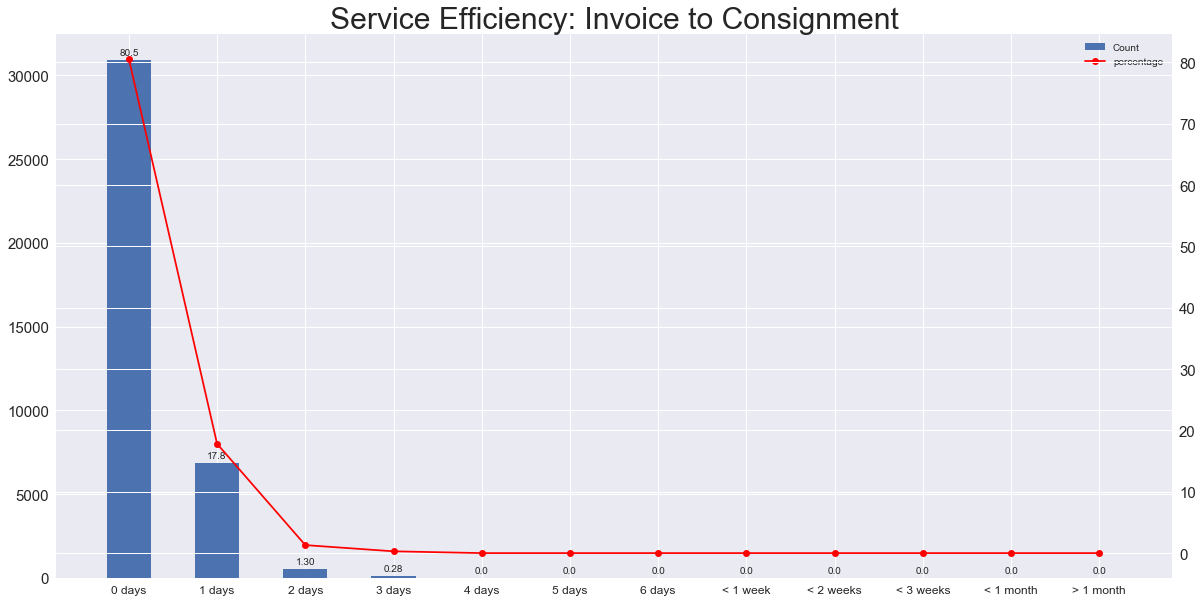

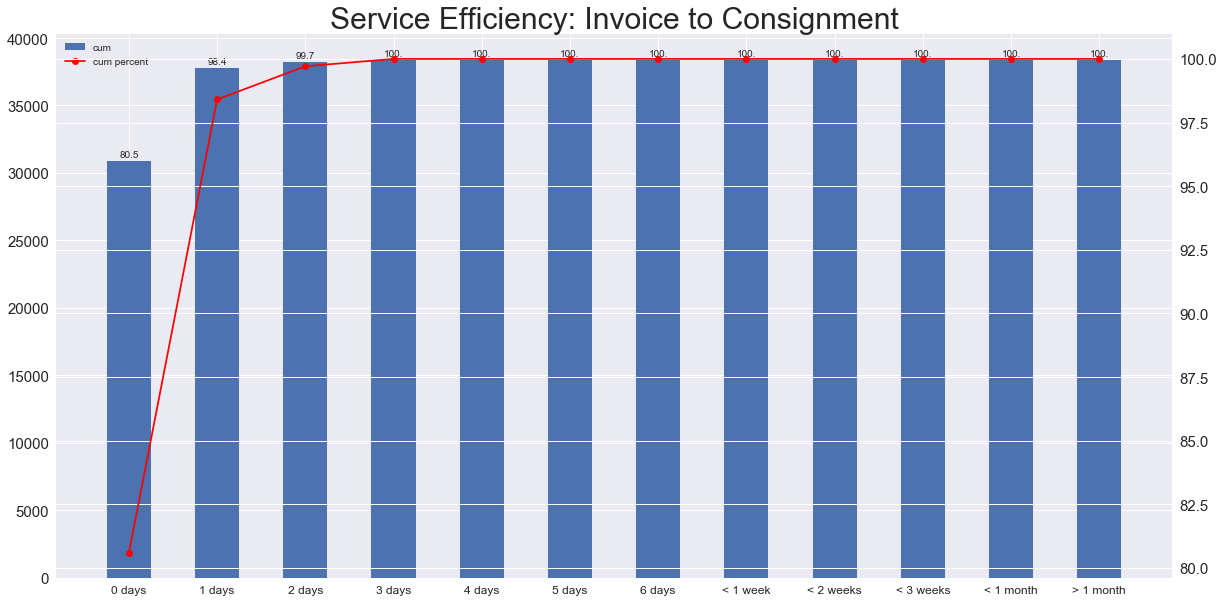

In [ ]:
tmp = bill_to_GC['BILL_TO_GC'].value_counts().reset_index()
tmp.columns = ['Days', 'Count']
tmp['Days'] = tmp['Days'].apply(lambda x: x.days)
tmp.sort_values(by=['Days'], inplace=True)
tmp = tmp.reset_index().drop('index', axis=1)
display_days_difference(tmp, 'Service Efficiency: Invoice to Consignment')

## 4. Consignment to receipt

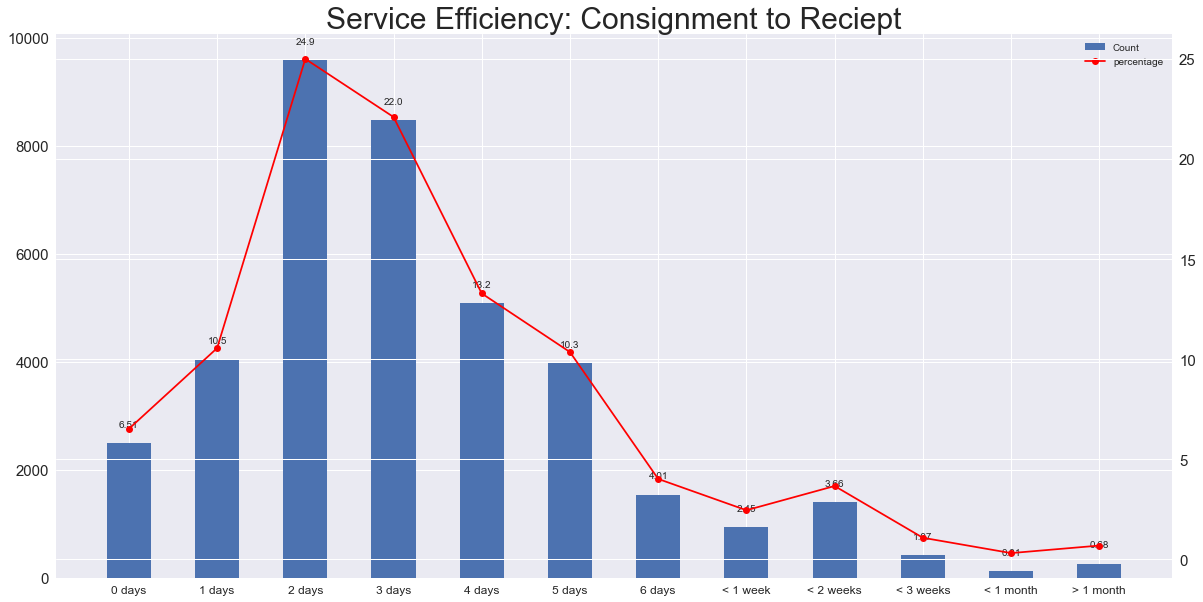

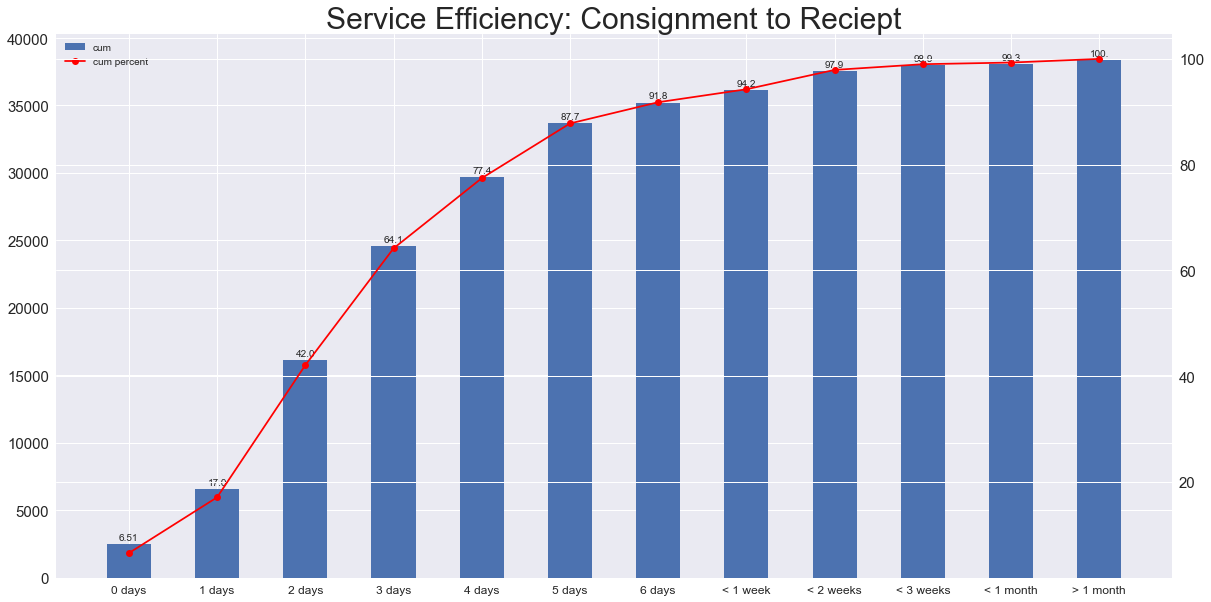

In [ ]:
GC_to_recpt = bill[['GC date', 'Recpt date']]
GC_to_recpt.loc[:, 'GC_TO_RECPT'] = GC_to_recpt['Recpt date'] - GC_to_recpt['GC date']
tmp = GC_to_recpt['GC_TO_RECPT'].value_counts().reset_index()
tmp.columns = ['Days', 'Count']
tmp['Days'] = tmp['Days'].apply(lambda x: x.days)
tmp.sort_values(by=['Days'], inplace=True)
tmp = tmp.reset_index().drop('index', axis=1)
display_days_difference(tmp, 'Service Efficiency: Consignment to Reciept')

## TOTAL TIME

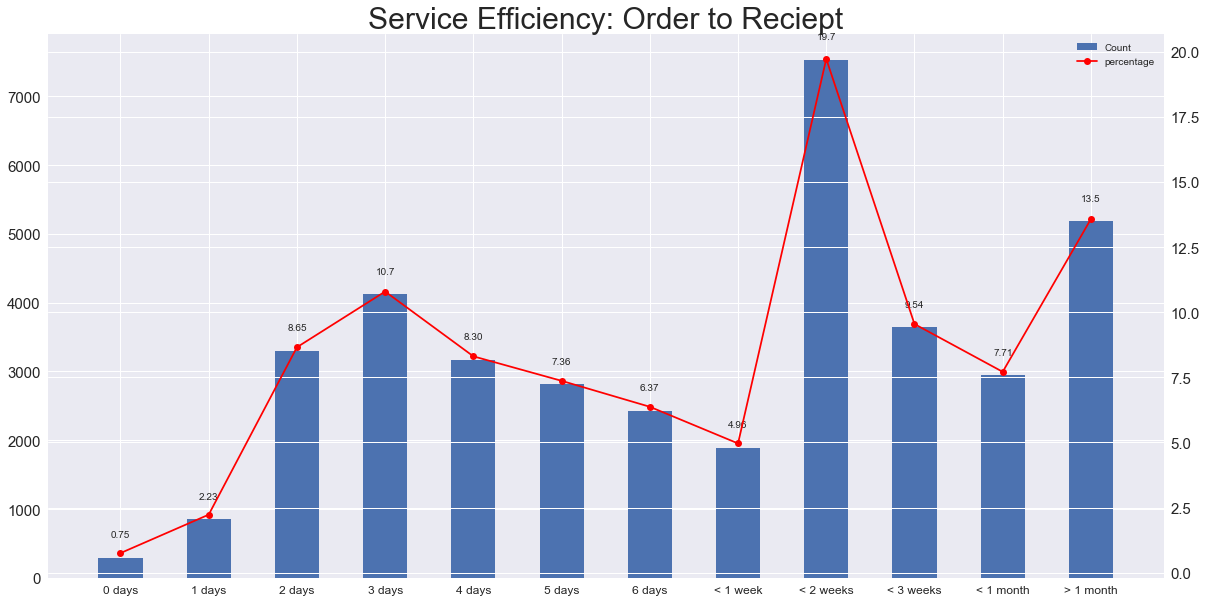

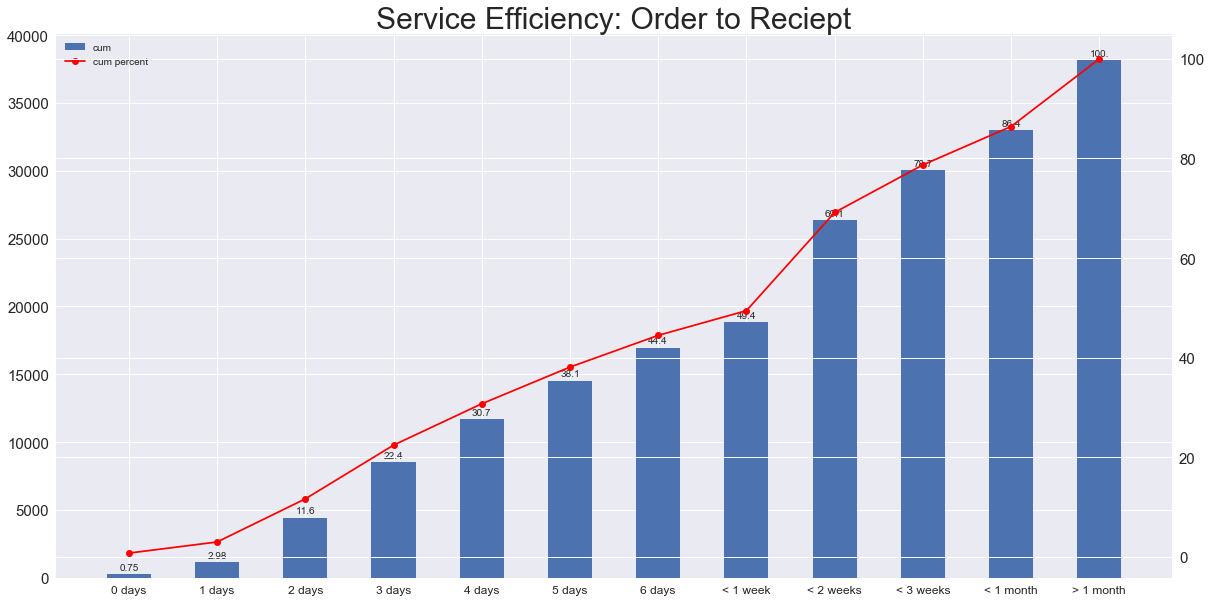

In [ ]:
PO_to_recpt = bill[['PO date', 'Recpt date']]
PO_to_recpt.loc[:, 'PO_TO_RECPT'] = PO_to_recpt['Recpt date'] - PO_to_recpt['PO date']
tmp = PO_to_recpt['PO_TO_RECPT'].value_counts().reset_index()
tmp.columns = ['Days', 'Count']
tmp['Days'] = tmp['Days'].apply(lambda x: x.days)
tmp.sort_values(by=['Days'], inplace=True)
tmp = tmp.reset_index().drop('index', axis=1)
display_days_difference(tmp, 'Service Efficiency: Order to Reciept')

# Customer wise sales


In [ ]:
tmp = customer[['customer code', 'Total_Price']]
tmp = tmp.groupby(['customer code']).sum().reset_index()
tmp.sort_values(by='Total_Price', ascending=False, inplace=True)
tmp = tmp.reset_index(drop=True)

tmp2 = tmp.loc[50:]
tmp = tmp.loc[:49]
tmp.loc[50] = ['Others', tmp2['Total_Price'].sum()]

[]

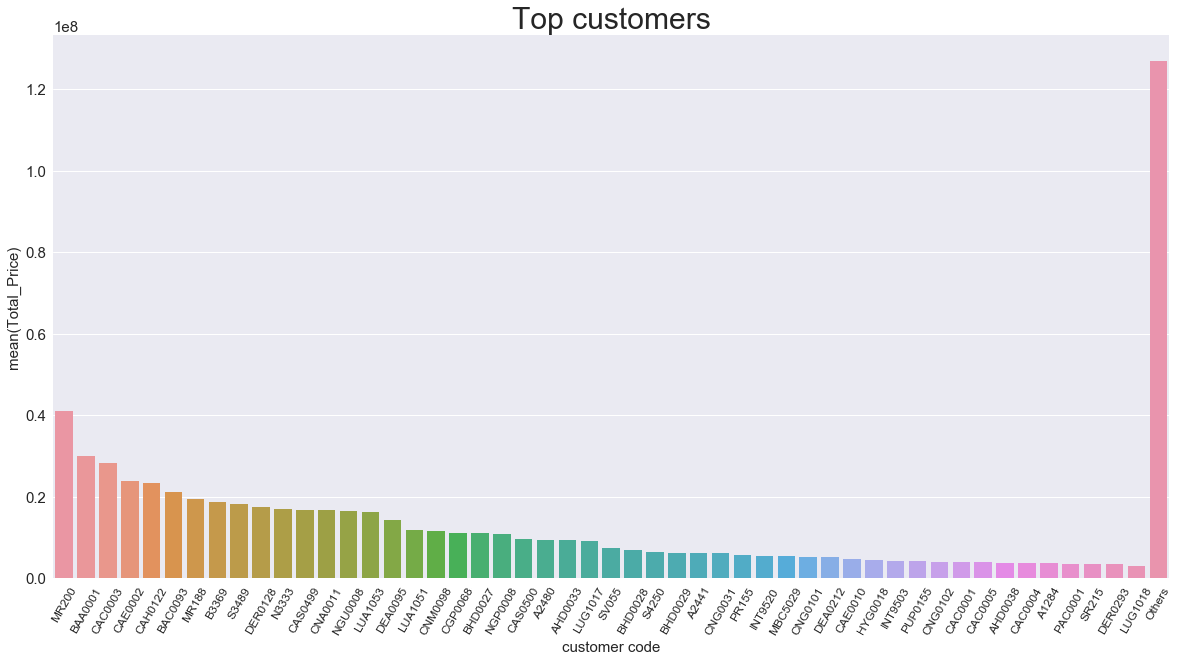

In [ ]:
sns.barplot(x='customer code', y='Total_Price', data=tmp)
plt.xticks(rotation=60)
plt.title("Top customers")
plt.plot()

# Region wise Sales

In [ ]:
df = customer.groupby('Region')['Total_Price'].sum().reset_index()
# sort by income
df = df.sort_values(by='Total_Price', ascending=False)
df = df.reset_index(drop=True)

[]

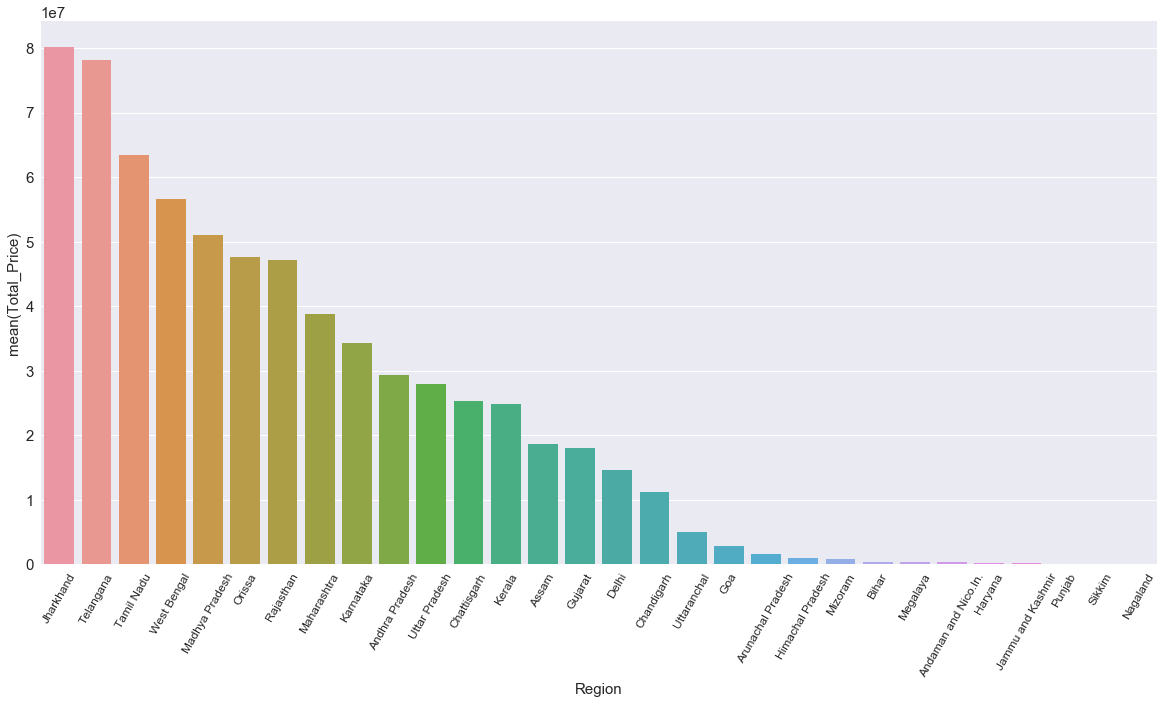

In [ ]:
#Plotting the region wise profit graph

sns.barplot(x = 'Region', y= 'Total_Price', data=df)
plt.xticks(rotation=60)
plt.plot()

# Material Wise Profit

In [ ]:
df = customer.groupby('PTNO')['Total_Price'].sum().reset_index()
# sort by income
df = df.sort_values(by='Total_Price', ascending=False)
df = df.reset_index(drop=True)

tmp = df.loc[50:]
df = df.loc[:49]
df.loc[50] = ['Others', tmp['Total_Price'].sum()]

[]

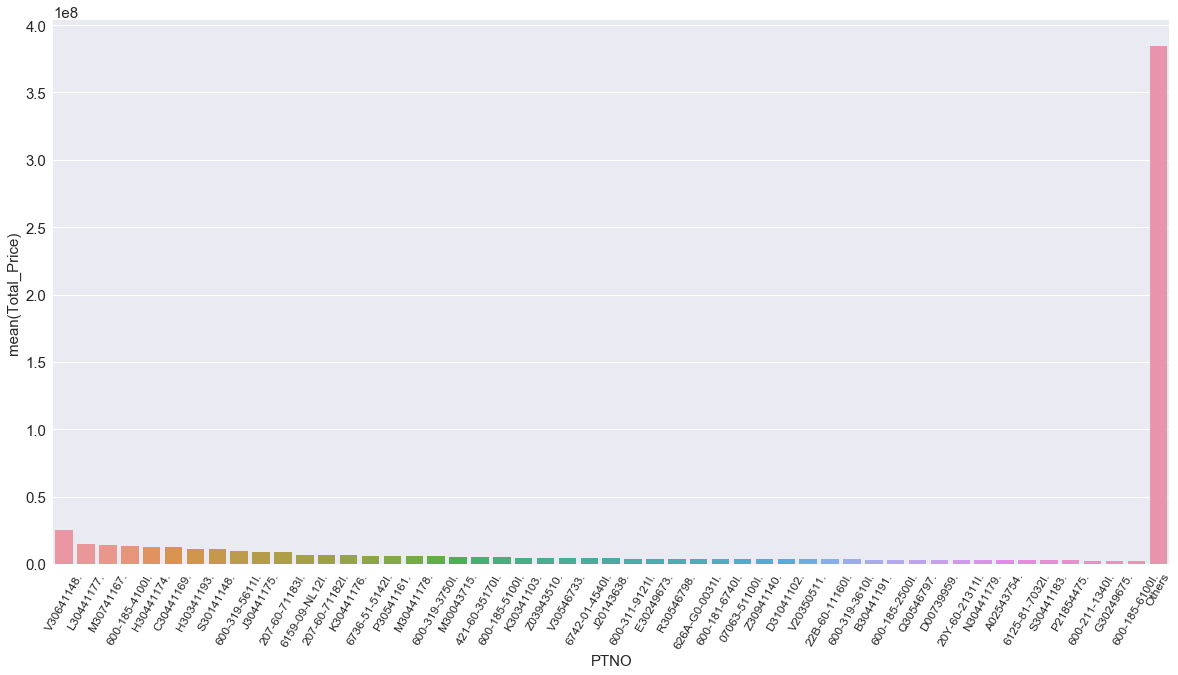

In [ ]:
#Plotting the region wise profit graph

sns.barplot(x = 'PTNO', y= 'Total_Price', data=df)
plt.xticks(rotation=60)
plt.plot()

# Model wise demand

In [ ]:
model_demand = material_master
model_demand = model_demand.groupby('Model').sum().reset_index()
model_demand.drop(['safety stock'], axis=1, inplace=True)
model = model_demand.sort_values(by='Demand', ascending=False)
model = model.reset_index(drop=True)

,Model,Demand
0,PC200,129526
1,PC300,61608
2,PC71,44963
3,PC210,34785
4,D155,32093
5,300CK,29608
6,PC130,26286
7,PC450,21973
8,Others,14919
9,OTHER,13158


In [ ]:
# 8, 9 is others, lets combine and remove them
tmp = model.loc[8:9]
model = model.drop([8, 9])
tmp

,Model,Demand
8,Others,14919
9,OTHER,13158


In [ ]:
model = model.reset_index(drop=True)
tmp = tmp.reset_index(drop=True)

In [ ]:
tmp

,Model,Demand
0,Others,14919
1,OTHER,13158


In [ ]:
tmp = pd.concat([tmp, model.loc[10:]])
model = model.loc[:9]
model.loc[10] = ['Others', tmp['Demand'].sum()]

[]

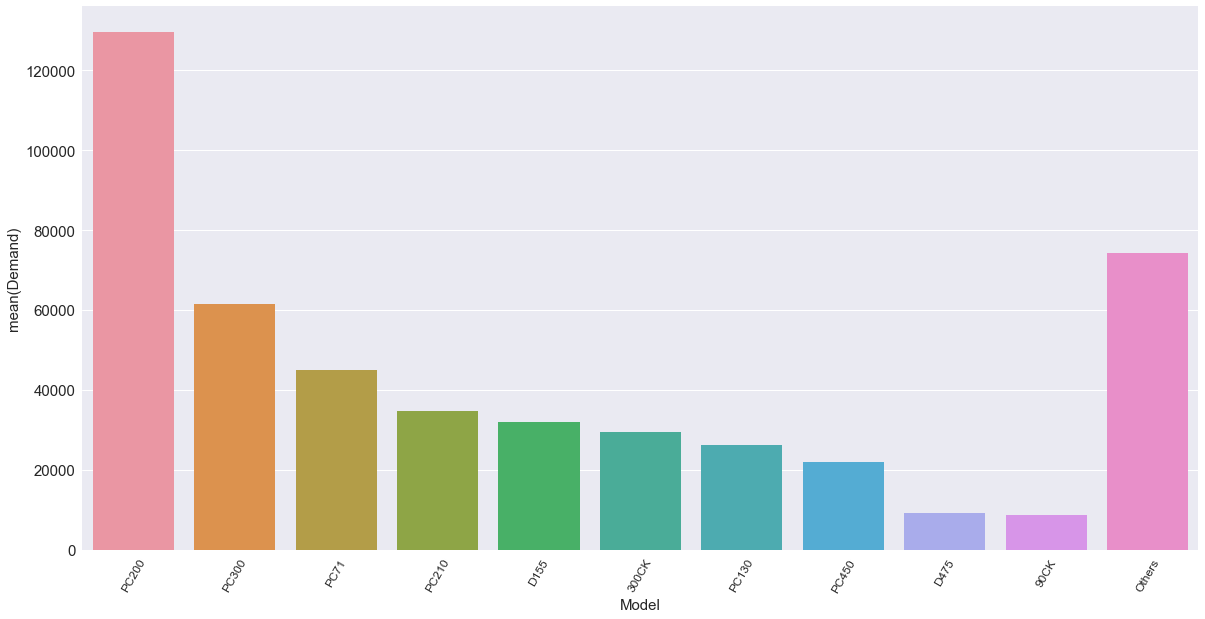

In [ ]:
sns.barplot(x = 'Model', y= 'Demand', data=model)
plt.xticks(rotation=60)
plt.plot()

# Pie chart to be displayed : Out of stock or stocks needed immediately

In [ ]:
stock_df = material_master.merge(stock_master,left_on='Material code',right_on = 'Material')
stock_df.drop(['Material Description','DocumentNo','D/C','Amount','BUn','Pstng Date','Material'],axis=1, inplace=True)

In [ ]:
stock_df = stock_df.groupby(['Material code','Model','safety stock'])['Quantity'].sum().reset_index()

In [ ]:
# checking for various conditions
def test (row):
   if row['safety stock'] < row['Quantity']  :
      return 'IN_STOCK'
   if row['safety stock'] > row['Quantity']  :
      return 'OUT_OF_STOCK'
   if row['safety stock'] == row['Quantity']  :
      return 'NEW_STOCK_NEEDED'

   return 'Other'

In [ ]:
stock_df['status'] = stock_df.apply (lambda row: test (row),axis=1)

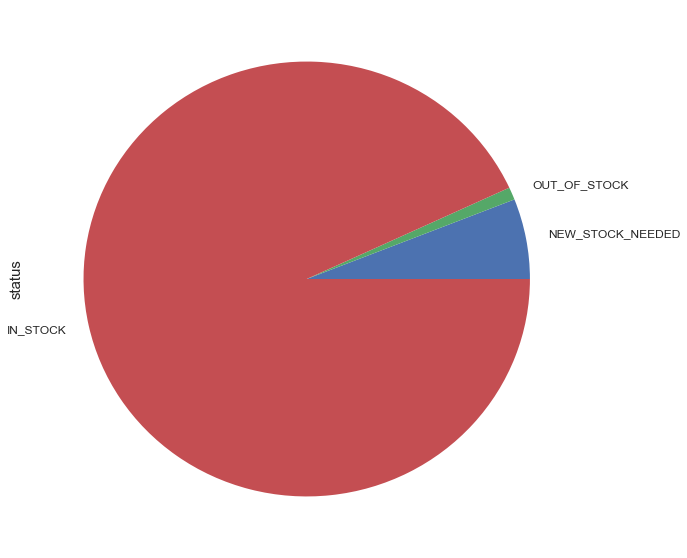

In [ ]:
#pie chart(using quantity and safety_stock)

plt.figure(figsize=(10, 10))
stock_df.status.value_counts(sort=False).plot(kind='pie')
plt.show()

# Season wise demand forecast


Here we try to find out how the demand for various products in the company vary with the seasons

First we split the order dates for each material according to seasons
We consider 5 seasons:   
1. Winter - November to Feb (11,12,1,2)
2. Spring - March to April (3,4)  
3. Summer - May to June (5,6)
4. Monsoon - July to August (7,8)  
5. Autumn - September to October (9,10)

 Lets get the month from 'PO date' and assign it to a new df

In [ ]:
df = customer[['PO date', 'Total_Price']]
df.loc[:, 'month'] = df['PO date'].apply(lambda x: x.month)
df = df.drop(['PO date'], axis=1)

In [ ]:
df = df.groupby(['month']).sum().reset_index()

In [ ]:
# checking for various conditions
def test_s (row):
   if (row['month'] ==1)|(row['month']==2)   :
      return 'winter'

   if (row['month'] ==3)|(row['month'] ==4)   :
      return 'spring'
   if (row['month'] ==5)|(row['month'] ==6)  :
      return 'summer'
   if (row['month']==7)|(row['month']==8) :
      return 'mansoon'
   if (row['month'] ==9)|(row['month'] ==10)   :
      return 'autumn'
   if (row['month'] ==11)|(row['month'] ==12)   :
      return 'winter'

In [ ]:
df['season'] = df.apply (lambda row: test_s (row),axis=1)
df = df.drop(['month'], axis=1)

In [ ]:
df = df.groupby('season').sum().reset_index()
df

,season,Total_Price
0,autumn,115282947
1,mansoon,190583361
2,spring,136098629
3,summer,229683886
4,winter,8753860


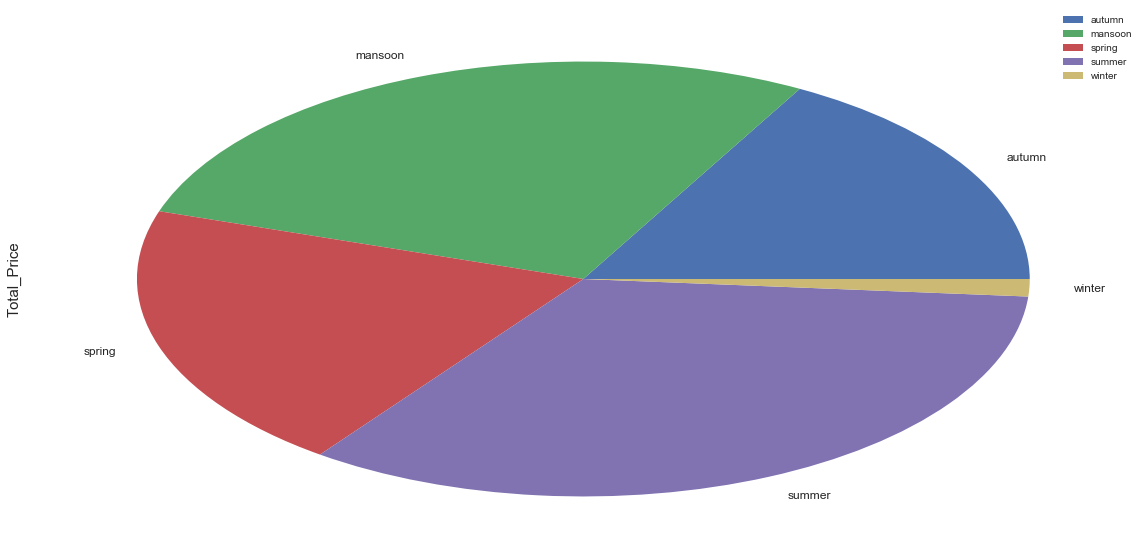

In [ ]:
plt.figure(figsize=(10, 10))
df.plot(kind='pie', y='Total_Price', labels=df['season'])
plt.show()

# Checking possible reason for delay from consignment to delivery

In [ ]:
GC_to_recpt = bill[['GC date', 'Recpt date', 'Consignment details']]
GC_to_recpt.loc[:, 'GC_TO_RECPT'] = GC_to_recpt['Recpt date'] - GC_to_recpt['GC date']
GC_to_recpt = GC_to_recpt.sort_values(by='GC_TO_RECPT', ascending=False)
GC_to_recpt = GC_to_recpt.groupby('Consignment details').sum().reset_index().sort_values(by='GC_TO_RECPT', ascending=False).reset_index(drop=True)

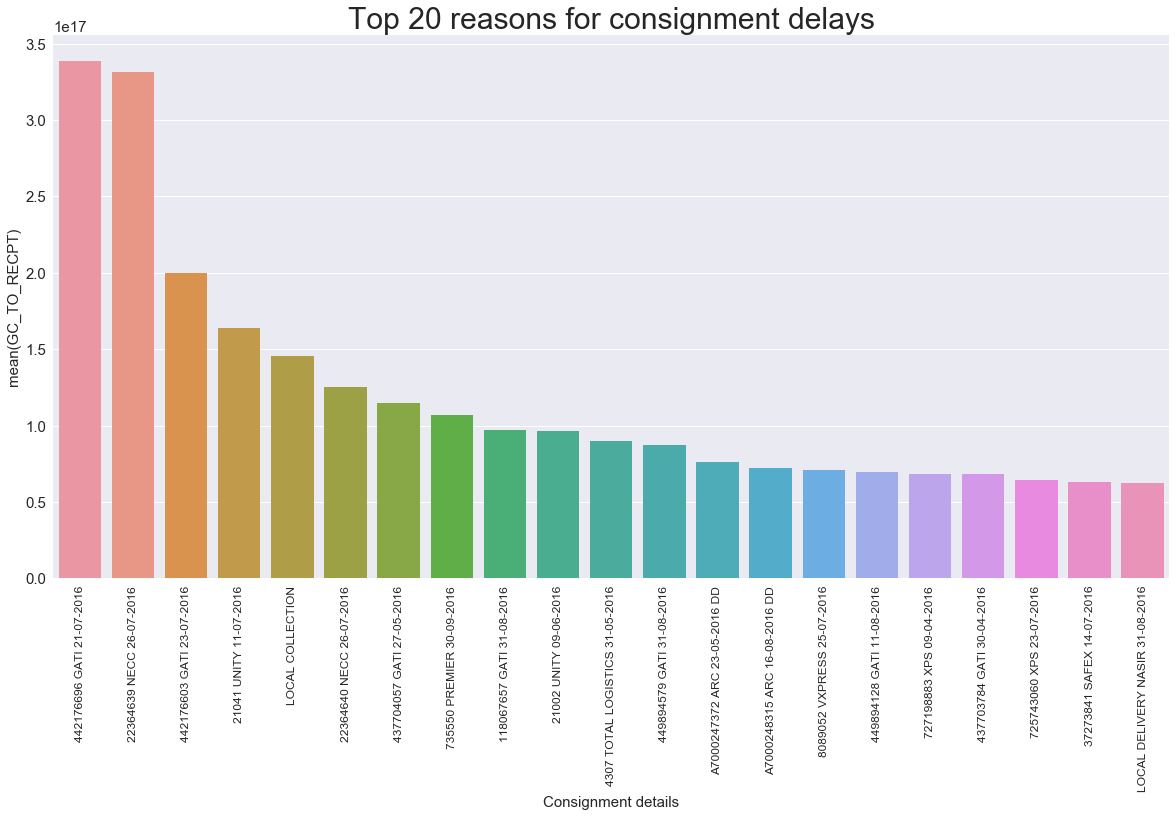

In [ ]:
# Top 20 reasons for consignment delays

GC_to_recpt = GC_to_recpt.loc[:20]
sns.barplot(y = 'GC_TO_RECPT', x= 'Consignment details', data=GC_to_recpt)
plt.xticks(rotation=90)
plt.title('Top 20 reasons for consignment delays')
plt.show()

# Query Drill down

In [ ]:
# Lets see if the orders fluctuate as per the date, you know if there
# is a season for most orders. Maybe end of fiscal year or start of new
# fiscal year, this would show optimal time to pump up production of parts

# df is a new dataframe created using the customer_order table, we only need
# to put emphasis on the date of orders and the Price.
df = customer[['PO date', 'Total_Price', 'ORD_QTY']]

In [ ]:
df = df.groupby(['PO date']).sum().reset_index()
df = df.sort_values(by=['PO date'])
df['PO date'] = pd.to_datetime(df['PO date'])

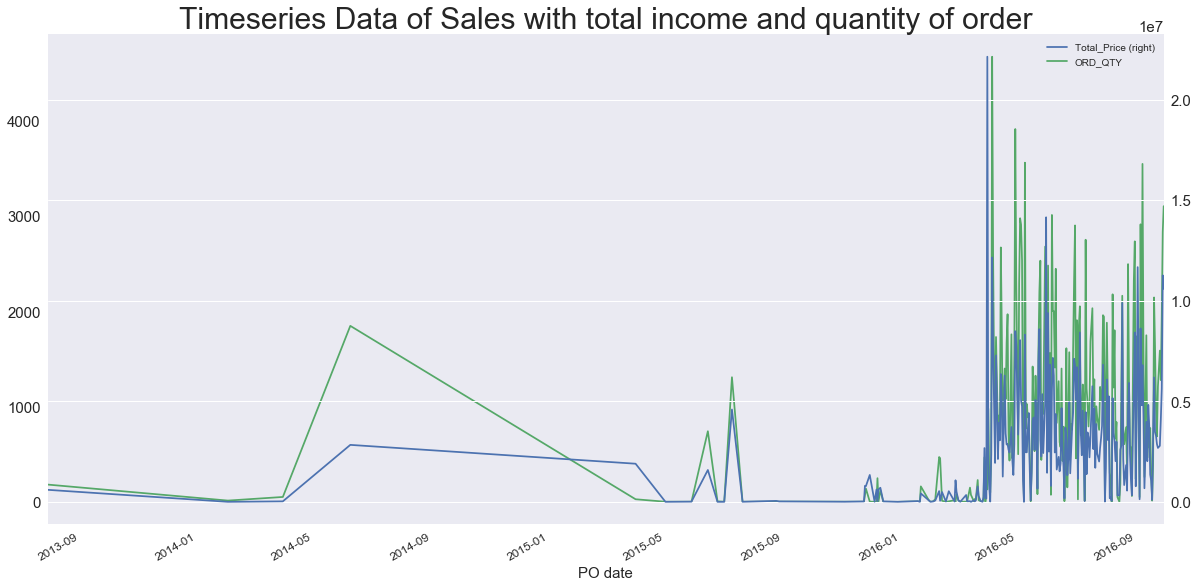

In [ ]:
ax = df.plot(x='PO date', y='Total_Price', secondary_y=True)
df.plot(x='PO date', y='ORD_QTY', ax=ax)
plt.title('Timeseries Data of Sales with total income and quantity of order')
plt.show()

### Month of the year

In [ ]:
df = customer[['PO date', 'Total_Price', 'ORD_QTY']]
df.loc[:,'month'] = df['PO date'].apply(lambda x: x.month)
df = df.drop(['PO date'], axis=1)
df = df.groupby(['month']).sum().reset_index()

In [ ]:
df

,month,Total_Price,ORD_QTY
0,1,534144,191
1,2,3298831,1099
2,3,27143439,1439
3,4,108955190,38685
4,5,120713266,38275
5,6,108970620,38315
6,7,104511662,34957
7,8,86071699,29733
8,9,115282947,35748
9,11,2934394,215


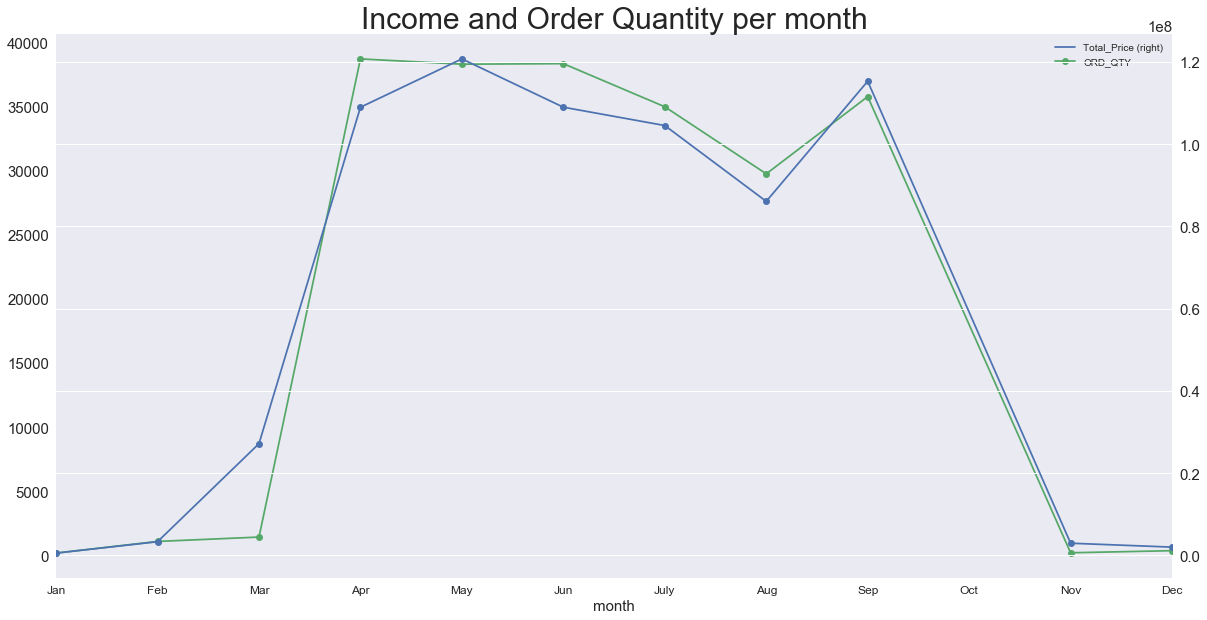

In [ ]:
ax = df.plot(x='month', y='Total_Price', secondary_y=True, marker='o')
df.plot(x='month', y='ORD_QTY', marker='o', ax=ax)
plt.xticks([x for x in xrange(1, 13)], ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'July', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.title('Income and Order Quantity per month')
plt.show()

### Day of the month

In [ ]:
df = customer[['PO date', 'Total_Price', 'ORD_QTY']]
df.loc[:,'day'] = df['PO date'].apply(lambda x: x.day)
df = df.drop(['PO date'], axis=1)
df = df.groupby(['day']).sum().reset_index()

In [ ]:
df.head()

,day,Total_Price,ORD_QTY
0,1,12893564,3604
1,2,30516498,8774
2,3,24459472,5732
3,4,26489072,7810
4,5,26719262,10069


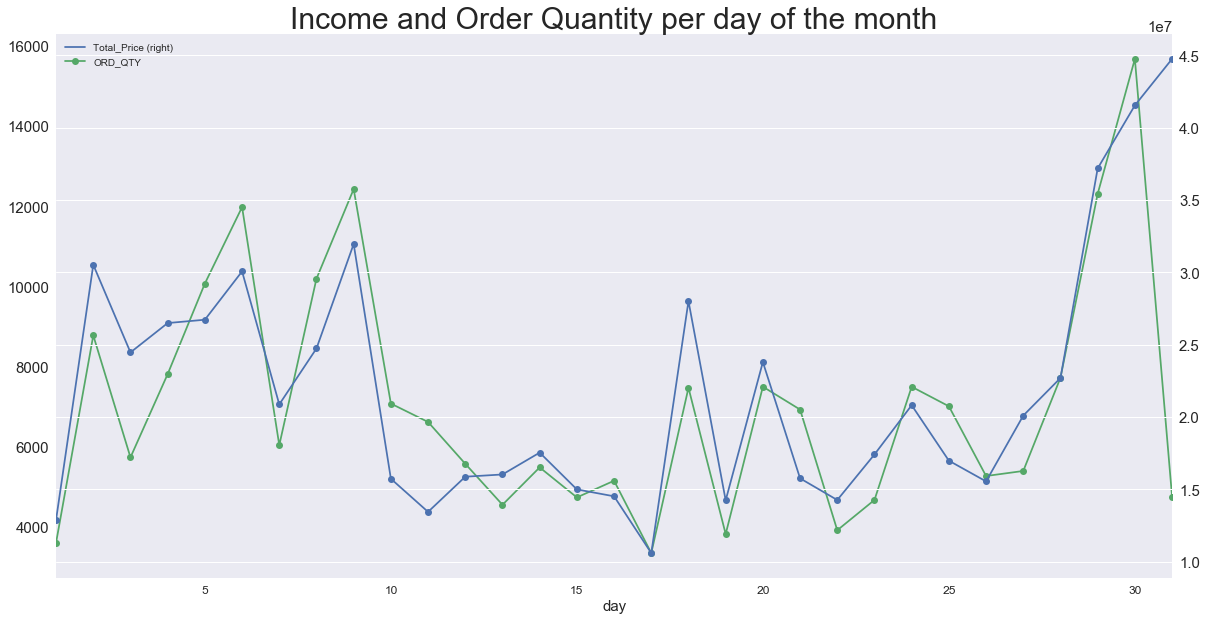

In [ ]:
ax = df.plot(x='day', y='Total_Price', secondary_y=True, marker='o')
df.plot(x='day', y='ORD_QTY', marker='o', ax=ax)
plt.title('Income and Order Quantity per day of the month')
plt.show()

### Machine Learning

In [ ]:
sales_past_demand.head()

,Material code,DEM36,DEM35,DEM34,DEM33,DEM32,DEM31,DEM30,DEM29,DEM28,...,DEM10,DEM9,DEM8,DEM7,DEM6,DEM5,DEM4,DEM3,DEM2,DEM1
0,01010-61435I.,6,0,0,0,0,0,5,0,0,...,0,4,0,0,16,12,2,0,0,0
1,01010-61455I.,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2,0,0
2,01010-61635I.,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,8,1,0
3,01010-61645I.,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,0
4,01010-61650I.,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,2,0,0,0,0


In [ ]:
tmp = sales_past_demand.drop(['Material code'], axis=1)

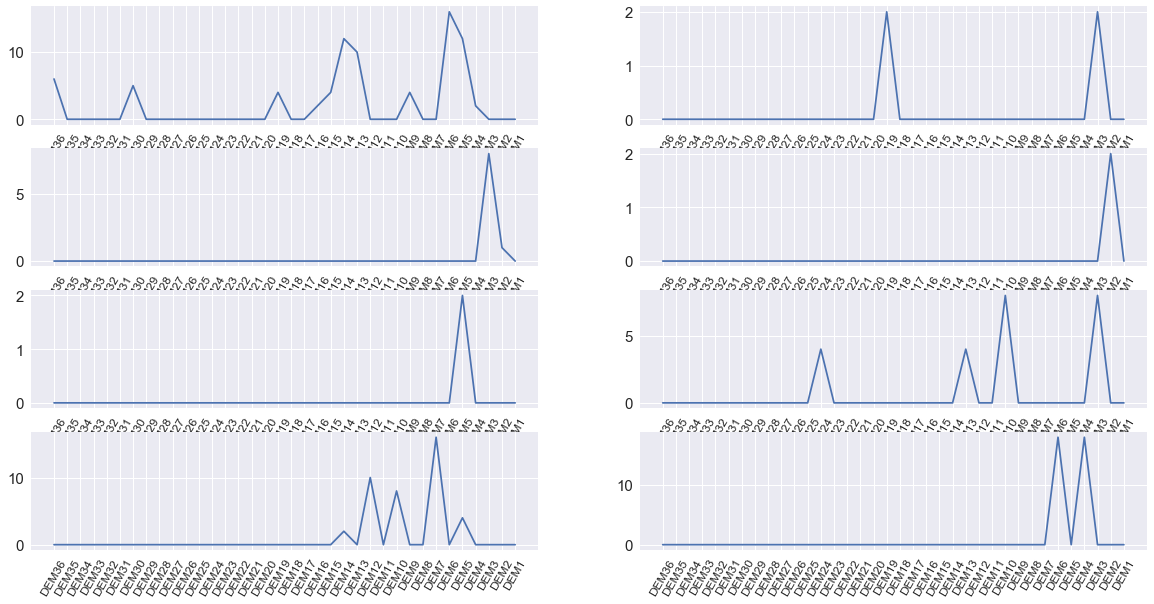

In [ ]:
for i in xrange(0, 8):
    plt.subplot(4, 2, i + 1)
    plt.plot([x for x in range(0, 36)], tmp.loc[i].values)
    plt.xticks([x for x in range(0, 36)], tmp.loc[i].index, rotation=60)
plt.show()

There is no periodicity in this whatsoever, perhaps we need to find other factors which influence these purchases? Or maybe we could try and represent data in some other form?

Instead of data per month, divide the data as to have data per 3 months. This allows us to predict the demand for the next three months which would be aggregated better than data per month.

In [ ]:
df = pd.DataFrame()
df['Material code'] = sales_past_demand['Material code']
for i in range(1, 37, 3):
    df['Q_' + str((i-1)/3)] = sales_past_demand[['DEM' + str(x) for x in range(i, i + 3)]].sum(axis=1)

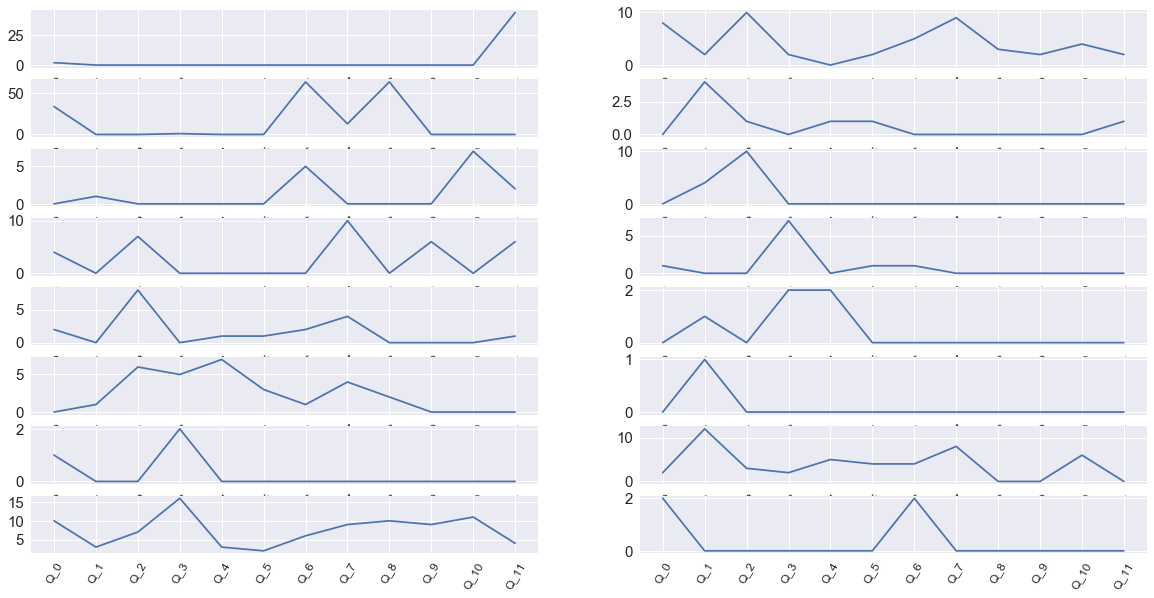

In [ ]:
tmp = df.drop(['Material code'], axis=1)
for i in xrange(0, 16):
    plt.subplot(8, 2, i + 1)
    plt.plot([x for x in range(0, 12)], tmp.loc[i+100].values)
    plt.xticks([x for x in range(0, 12)], tmp.loc[i+100].index, rotation=60)
plt.show()

Here, we can some sort of patterns. this could be predicted well. First lets see the prediction value, if we predict 0 for Q_11 by default.

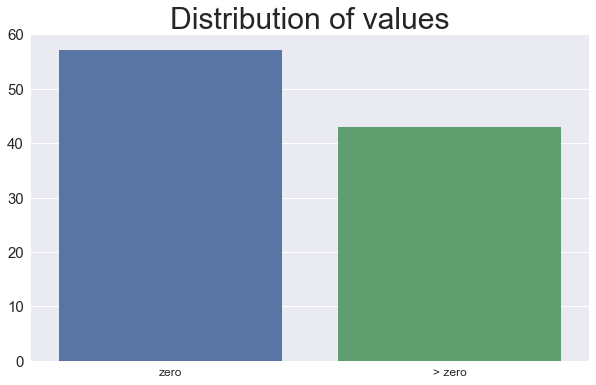

If we predict the demand to be zero every time, our accuracy would therefore be: 57.1072733311 %


In [ ]:
x = len(tmp[tmp['Q_11'] == 0])/float(len(tmp))
y = 1 - x
x = x * 100
y = y * 100
plt.figure(figsize=(10, 6))
plt.title('Distribution of values')
sns.barplot(y = [x, y], x = ['zero', '> zero'])
plt.show()
print 'If we predict the demand to be zero every time, our accuracy would therefore be:', x, '%'

So are prediction should at minimum perform better than 57%. Lets drop the 'Material code' since we're training our model to predict the demand for any given material Quaters.  

So we've split the data into quarters (3 months). Since we have data of 36 months, this gives us 12 quarters. So the idea is to train the model on 11 quarters so that it is able to predict the 12th quarter.

In [ ]:
df = df.drop(['Material code'], axis=1)
df.columns

Index([u'Q_0', u'Q_1', u'Q_2', u'Q_3', u'Q_4', u'Q_5', u'Q_6', u'Q_7', u'Q_8',
       u'Q_9', u'Q_10', u'Q_11'],
      dtype='object')

## Regression

Now we have our desired inputs and desired outputs. But it wouldn't make sense to train the machine learning algorithm and test it on the same data, so we'll now split our data into training and tests sets (70% - 30%).

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df.drop('Q_11', axis=1), df.Q_11, test_size=.3, random_state=42)

Now given the Training and testing set, we can use GridSearchCV to find best model for the given data.

#### ElasticNet

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNet

param = {'alpha': [1.0, 2, 5, 10, 50, 100, 1000], 'normalize': [True, False]}
reg = GridSearchCV(ElasticNet(), param)
reg.fit(X_train, y_train)
reg.score(X_test, y_test)

0.86167075983978569

In [ ]:
reg.best_params_

{'alpha': 100, 'normalize': False}

#### Lasso

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso

param = {'alpha': [1.0, 2, 5, 10, 50, 100, 1000], 'normalize': [True, False]}
reg = GridSearchCV(Lasso(), param)
reg.fit(X_train, y_train)
reg.score(X_test, y_test)

0.84968164809059832

In [ ]:
reg.best_params_

{'alpha': 100, 'normalize': False}

#### Ridge

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge

param = {'alpha': [1.0, 10, 100], 'normalize': [True, False], 'solver' : ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag']}
reg = GridSearchCV(Ridge(), param)
reg.fit(X_train, y_train)
reg.score(X_test, y_test)

0.87287512860147776

In [ ]:
reg.best_params_

{'alpha': 100, 'normalize': False, 'solver': 'sag'}

#### AdaboostRegressor

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostRegressor

param = {'n_estimators': [50, 100, 500], 'loss': ['linear', 'square', 'exponential']}
reg = GridSearchCV(AdaBoostRegressor(), param)
reg.fit(X_train, y_train)
reg.score(X_test, y_test)

0.74447372512362997

In [ ]:
reg.best_params_

{'loss': 'linear', 'n_estimators': 50}

### Picking the best model

Since we got the highest score with the Ridge model, we'll use it to do our predictions.

In [ ]:
from sklearn.linear_model import Ridge

reg = Ridge(alpha=100, normalize=False, solver='sag')
reg.fit(X_train, y_train)
reg.score(X_test, y_test)

0.87211240115639543

Lets compare the prediction with the actual values

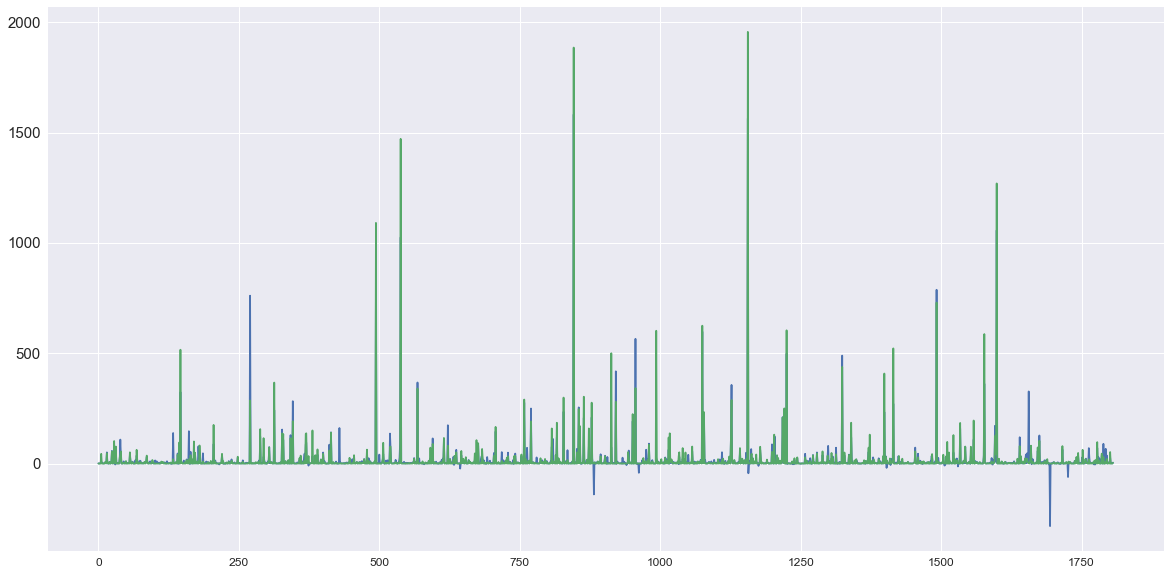

In [ ]:
pred = reg.predict(X_test)
plt.plot(pred)
plt.plot(y_test.values)
plt.show()

Zooming in a little:

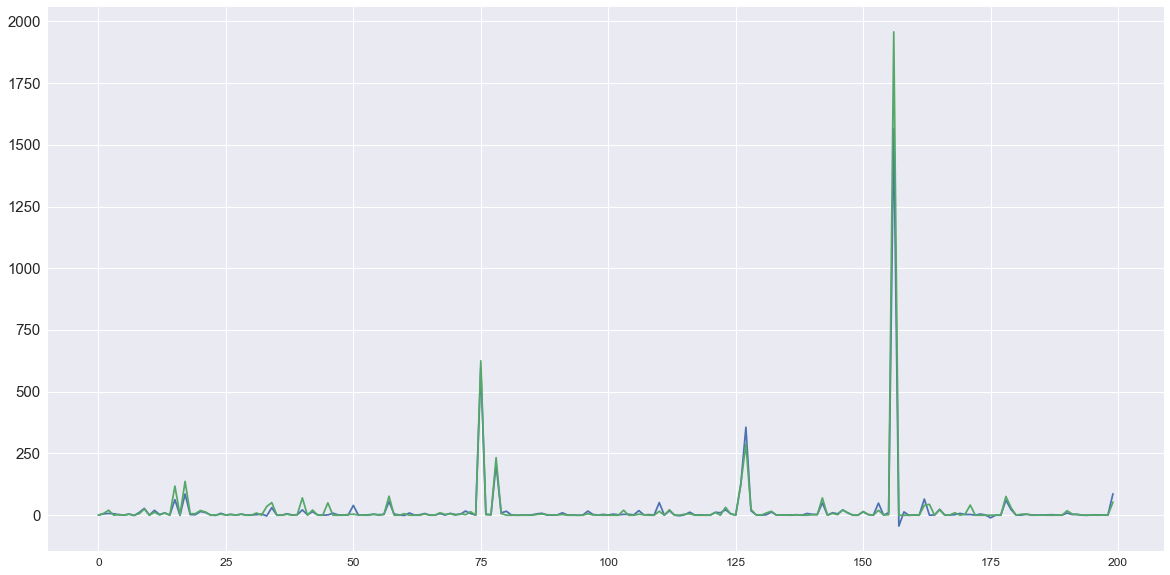

In [ ]:
plt.plot(pred[1000:1200])
plt.plot(y_test.values[1000:1200])
plt.show()

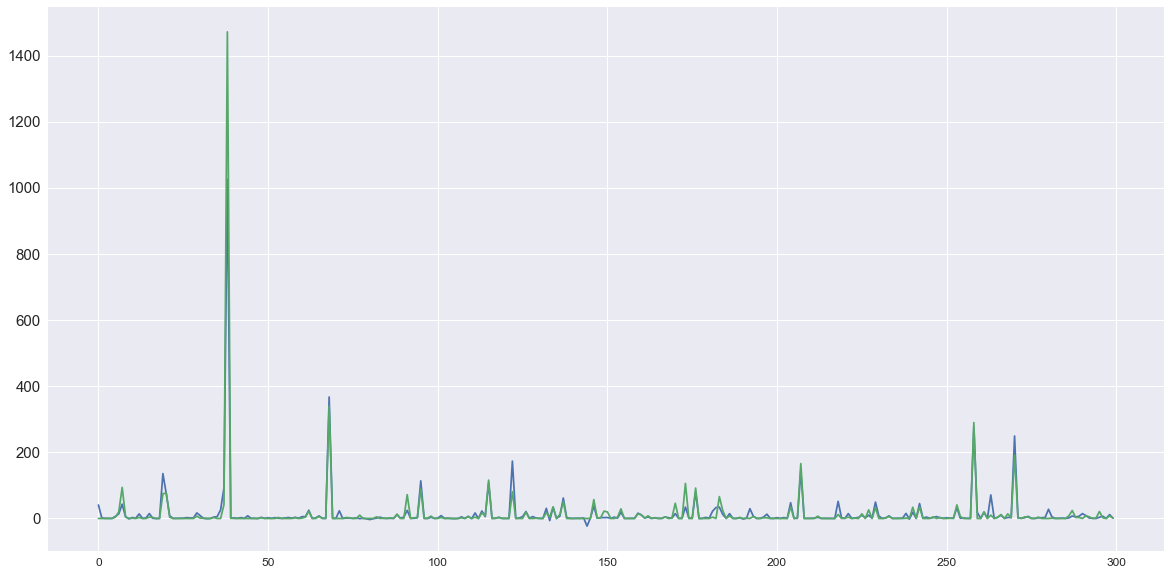

In [ ]:
plt.plot(pred[500:800])
plt.plot(y_test.values[500:800])
plt.show()